In [1]:
''' Generates several ROMs of varying dimensions and saves them to directory at npz and mat formats'''
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
 
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
from scipy.signal import cont2discrete
import pyvista as pv
import h5py
import mat73
import dask.array as da
from dask.distributed import Client, LocalCluster
import opinf
config = dotenv_values(".env")
from util import *


In [2]:


####### Set up dask cluster #######
# Setup Dask client
# cluster = LocalCluster() # Launches a scheduler and workers locally
# client = Client(cluster) # Connect to distributed cluster and override default
client = Client('tcp://127.0.0.1:8786')
client.cluster

In [3]:

####### # Set up hyperparameters for all ROMs  #######
n_timesteps = 2000 # Number of timesteps to pull from each episode
dt = 0.001
n_train = 3 # Number of training episodes
ns_ROM = np.arange(2,202,2) # Dimensions of ROM state space



In [4]:


####### Set up filepaths #######
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/archivedDataSets/FullAssembly_Constrained_FullSetForRAL_goodMatParams/"
romDir = config["currentDirectory"] + "data/archivedDataSets/FullAssembly_Constrained_FullSetForRAL_goodMatParams/ROMs/"


In [5]:

####### Load in data #######
print("Loading in data...")
# Read in all training data 
data = h5py.File(filepath+ "fullDataSet.hdf5", 'r')
X_fom = da.from_array(data["stateData"], chunks=(4096, 4096,1))
X_fom = X_fom[:,:,0:n_train]
U_fom = da.from_array(data["inputData"], chunks=(4096, 4096,1))
U_fom = U_fom[:,:,0:n_train]
Y_fom = da.from_array(data["reducedCenterlineData"], chunks=(4096, 4096,1))
Y_fom = Y_fom[:,:,0:n_train]
x0 = data["stateData"][:,0,0]
y0 = data["reducedCenterlineData"][:,0,0]
n = X_fom.shape[0]
l = U_fom.shape[0]
m = Y_fom.shape[0]
# # Collect initial condition offsets for each episode and center each episode
X0 = da.zeros((n,n_train))
Y0 = da.zeros((m,n_train))
for i in range(n_train):
    X0[:,i] = X_fom[:,0,i]
    Y0[:,i] = Y_fom[:,0,i]
    X_fom[:,:,i] = X_fom[:,:,i] - X0[:,i].reshape(-1,1)
    Y_fom[:,:,i] = Y_fom[:,:,i] - Y0[:,i].reshape(-1,1)
print("Done loading in data.")


Loading in data...
Done loading in data.


In [6]:

# Get length of robot from min and max of x coords
xzCoords = Y0[:,0].reshape(-1,2)

x_min = np.min(xzCoords[:,0])
x_max = np.max(xzCoords[:,0])
length = x_max - x_min
print("Length of robot: ", length.compute())
# Get z min and max
z_min = np.min(xzCoords[:,1])
z_max = np.max(xzCoords[:,1])


Length of robot:  1110.065638621652


In [7]:

# Print shapes of data
# print("Shape of X_fom: ", X_fom.shape)
# print("Shape of U_fom: ", U_fom.shape)
# print("Shape of Y_fom: ", Y_fom.shape)


# ####### Generate ROMs for Each Method #######
# # OKID + ERA
# print("Generating OKID + ERA ROMs...")
# U_era = U_fom[:,:,0]
# Y_era = Y_fom[:,:,0]
# ## OKID
# YY = Y_era
# UU_size = (U_era.shape[0]*U_era.shape[1],U_era.shape[1])
# UU = da.zeros(UU_size)
# for i in range(U_era.shape[1]):
#     startRow = i*U_era.shape[0]
#     endRow = (i+1)*U_era.shape[0]
#     UU[startRow:endRow,i:] = U_era[:,0:(U_era.shape[1]-i)]
# # compute pseudoinverse of input matrix using SVD
# U_UU, S_UU, Vh_UU = da.linalg.svd(UU)
# UU_pinv = da.matmul(da.transpose(Vh_UU),da.matmul(da.diag(1/S_UU),da.transpose(U_UU)))
# # Solve for impulse response  
# IR = da.matmul(YY,UU_pinv)
# # Compute things to limit growth of computation graph
# IR = IR.compute()

# ## ERA
# # Form Hankel matrix for ERA 
# N = int(n_timesteps/2-1)
# H_size = (m*N,l*N)

# H = np.zeros(H_size)
# Hprime = np.zeros(H_size)

# for i in range(N):
#     startRow = m*i 
#     endRow = m*(i+1)
#     H[startRow:endRow,:]=IR[:,l*(1+i):l*(1+i+N)]
#     Hprime[startRow:endRow,:]=IR[:,l*(2+i):l*(2+i+N)]

# H = da.from_array(H, chunks=(2048,H.shape[1]))
# Hprime = da.from_array(Hprime, chunks=(2048,Hprime.shape[1]))
# IR = da.from_array(IR, chunks=(IR.shape[0],4096))
# # Get SVD of Hankel matrix
# U_full, S_full, Vh_full = da.linalg.svd_compressed(H, 1000)

# for n_ROM in ns_ROM:

#     print("Computing ERA system matrices for n_ROM = ", n_ROM)
#     # Truncate SVD
#     U = U_full[:,:n_ROM]
#     S = da.diag(S_full[:n_ROM])
#     Vh = Vh_full[:n_ROM,:]

#     # Compute trunacted SVD values
#     U, S, Vh = da.compute(U, S, Vh)
#     # Convert np arrays back into dask arrays
#     U = da.from_array(U)
#     Vh = da.from_array(Vh)
#     S = da.from_array(S)

#     # Solve for system matrices
#     Sigma_tilde_is = da.linalg.inv(da.sqrt(S)) # inverse squareroot of sigma matrix
#     Sigma_tilde_sqrt = da.sqrt(S) # squareroot of sigma matrix


#     Em = da.concatenate([da.eye(l),da.zeros((l*(N-1),l))],axis=0)
#     Ep = da.concatenate([da.eye(m),da.zeros((m*(N-1),m))],axis=0)

#     A_era = da.matmul(da.matmul(da.matmul(da.matmul(Sigma_tilde_is,da.transpose(U)),Hprime),da.transpose(Vh)),Sigma_tilde_is)
#     B_era = da.matmul(da.matmul(Sigma_tilde_sqrt,Vh),Em)
#     C_era = da.matmul(da.transpose(Ep),da.matmul(U,Sigma_tilde_sqrt))
#     D_era = IR[:,:l]

#     A_era, B_era, C_era, D_era = da.compute(A_era, B_era, C_era, D_era)

#     # Save system matrices, projection mappings, and initial offset into file for later use
#     np.savez(romDir+f"eraSystemMatrices_{n_ROM}dim_{n_train}train.npz", A_era=A_era, B_era=B_era, C_era=C_era, D_era=D_era, x0=x0, y0=y0)
#     # save as .mat file
#     scipy.io.savemat(romDir+f"eraSystemMatrices_{n_ROM}dim_{n_train}train.mat", mdict={'A_era': A_era, 'B_era': B_era, 'C_era': C_era, 'D_era': D_era, 'x0': x0, 'y0': y0})

#     # clean up memory 
#     # del U_era, Y_era, YY, UU, IR, H, Hprime, U, S, Vh, Sigma_tilde_is, Sigma_tilde_sqrt, Em, Ep, A_era, B_era, C_era, D_era
# print("Done generating OKID + ERA ROMs.")


In [8]:

####### Generate DMDc ROMs #######
print("Generating DMDc ROMs...")
print("got here 1")
# Initialize data matrices for training and testing
X_train = da.zeros((n,(n_timesteps-1)*n_train), chunks=(4096, 4096))
Xprime_train = da.zeros((n,(n_timesteps-1)*n_train), chunks=(4096, 4096))
Upsilon_train = da.zeros((l,(n_timesteps-1)*n_train), chunks=(4096, 4096))
Y_train = da.zeros((m,(n_timesteps-1)*n_train), chunks=(4096, 4096))
print("got here 2")
# Load in data from training episodes
for i in range(n_train):
    X_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = X_fom[:,:-1,i]
    Xprime_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = X_fom[:,1:,i]
    Upsilon_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = U_fom[:,:-1,i]
    Y_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = Y_fom[:,:-1,i]
print("got here 3")
# Form snapshot matrices for DMDc
Omega = da.concatenate([X_train,Upsilon_train],axis=0)
Omega = Omega.rechunk((2000,Omega.shape[1])) # Rechunk along height
print("got here 4")
p_dmd = 5000
U_tilde,Sigma_tilde,Vh_tilde = da.linalg.svd(Omega)
singularVals = Sigma_tilde.compute()
# Print shapes of svd matrices
print("Shape of U_tilde: ", U_tilde.shape)
print("Shape of Sigma_tilde: ", Sigma_tilde.shape)
print("Shape of Vh_tilde: ", Vh_tilde.shape)
# for n_ROM in ns_ROM:
#     # Decompose snapshot matrix using truncated SVD
#     p_dmd = 5000
#     r_dmd = n_ROM
#     print("got here 5")
#     U_tilde,Sigma_tilde,Vh_tilde = da.linalg.svd_compressed(Omega, p_dmd)
#     # Vh_tilde = da.conj(da.transpose(V_tilde))
#     Sigma_tilde = da.diag(Sigma_tilde)
#     U_hat, Sigma_hat, V_hat = da.linalg.svd_compressed(Xprime_train, r_dmd)
#     Sigma_hat = da.diag(Sigma_hat)
#     print("got here 6")
#     # Compute system state evolution matrices
#     U_tilde_1 = U_tilde[0:n,:]
#     U_tilde_2 = U_tilde[n:,:]
#     A_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_1.conj().T)@U_hat
#     B_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_2.conj().T)

#     print("got here 7")

#     # Solve for system output matrix from full order system
#     ys = Y_train[:,0:100]

#     # compute approximate pseudoinverse of data matrix using SVD
#     # X_train = X_train.rechunk((2000,X_train.shape[1])) # Rechunk along one dimension
#     U_X_train, S_X_train, Vh_X_train = da.linalg.svd(X_train[:,0:100])
#     X_PI = da.matmul(da.transpose(Vh_X_train),da.matmul(da.diag(da.reciprocal(S_X_train)),da.transpose(U_X_train)))

#     print("got here 8")

#     # # X_PI = np.linalg.pinv(X_train[:,0:10])
#     C_dmdc = ys@X_PI
#     C_dmdc = C_dmdc@U_hat
#     print("got here 9")
#     # Execute computations for dmdc system matrices
#     print("Computing DMDc system matrices for n_ROM = ", n_ROM)
#     A_dmdc, B_dmdc, C_dmdc,U_hat = da.compute(A_dmdc, B_dmdc, C_dmdc,U_hat)
#     # A_dmdc, B_dmdc = da.compute(A_dmdc, B_dmdc)
#     # A_dmdc = A_dmdc.compute()
#     print("got here 10")
#     # B_dmdc = B_dmdc.compute()
#     # print("got here 11")
#     # C_dmdc = C_dmdc.compute()
#     # print("got here 12")
#     # U_hat = U_hat.compute()
#     # print("got here 13")
#     basis_dmdc = U_hat[:,0:n_ROM]
#     # Save system matrices, projection mappings, and initial offset into file for later use
#     np.savez(romDir+f"dmdcSystemMatrices_{n_ROM}dim_{n_train}train.npz", A_dmdc=A_dmdc, B_dmdc=B_dmdc, C_dmdc=C_dmdc, x0=x0, y0=y0, basis_dmdc=basis_dmdc)
#     # save as .mat file
#     scipy.io.savemat(romDir+f"dmdcSystemMatrices_{n_ROM}dim_{n_train}train.mat", mdict={'A_dmdc': A_dmdc, 'B_dmdc': B_dmdc, 'C_dmdc': C_dmdc, 'x0': x0, 'y0': y0, 'basis_dmdc': basis_dmdc})

# print("Done generating DMDc ROMs.")

Generating DMDc ROMs...
got here 1
got here 2
got here 3
got here 4
Shape of U_tilde:  (231342, 5997)
Shape of Sigma_tilde:  (5997,)
Shape of Vh_tilde:  (5997, 5997)


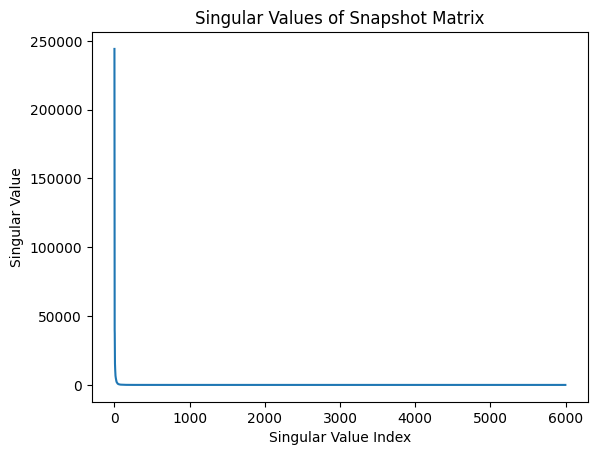

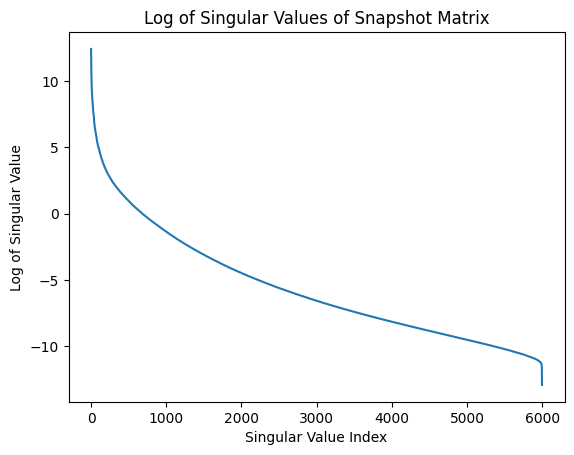

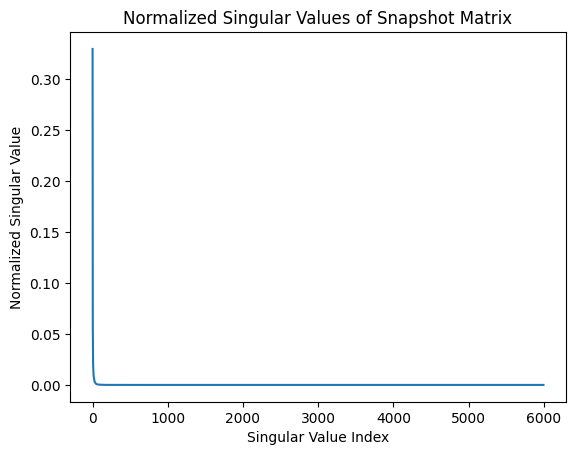

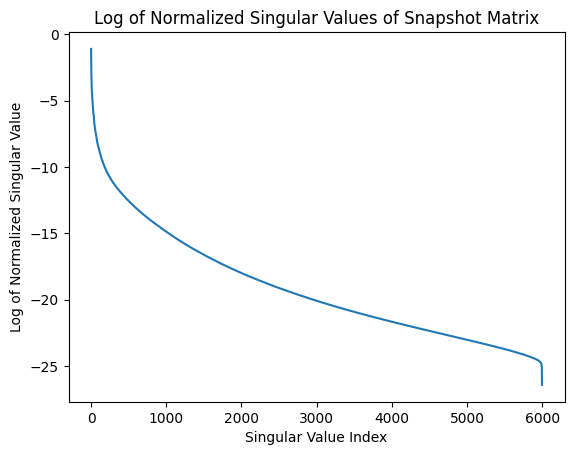

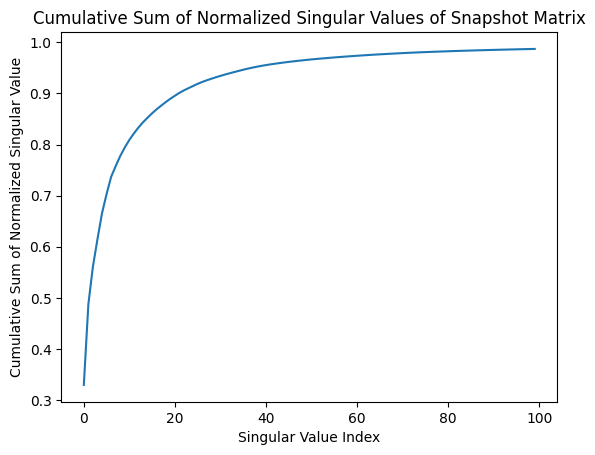

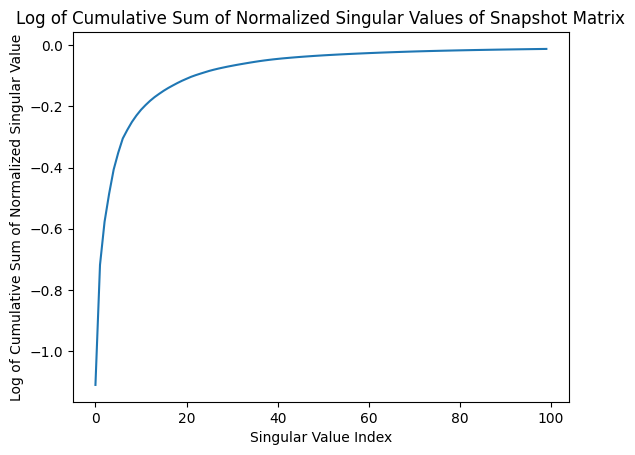

In [14]:
# Plot singular values
plt.figure()
plt.plot(singularVals)
plt.title("Singular Values of Snapshot Matrix")
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value")
# Plot log of singular values
plt.figure()
plt.plot(np.log(singularVals))
plt.title("Log of Singular Values of Snapshot Matrix")
plt.xlabel("Singular Value Index")
plt.ylabel("Log of Singular Value")
# Plot normalized singular values
plt.figure()
plt.plot(singularVals/np.sum(singularVals))
plt.title("Normalized Singular Values of Snapshot Matrix")
plt.xlabel("Singular Value Index")
plt.ylabel("Normalized Singular Value")
# Plot log of normalized singular values
plt.figure()
plt.plot(np.log(singularVals/np.sum(singularVals)))
plt.title("Log of Normalized Singular Values of Snapshot Matrix")
plt.xlabel("Singular Value Index")
plt.ylabel("Log of Normalized Singular Value")
plt.show()
# Plot cumulative sum of normalized singular values
plt.figure()
plt.plot(np.cumsum(singularVals/np.sum(singularVals))[:100])
plt.title("Cumulative Sum of Normalized Singular Values of Snapshot Matrix")
plt.xlabel("Singular Value Index")
plt.ylabel("Cumulative Sum of Normalized Singular Value")
# Plot log of cumulative sum of normalized singular values
plt.figure()
plt.plot(np.log(np.cumsum(singularVals/np.sum(singularVals)))[:100])
plt.title("Log of Cumulative Sum of Normalized Singular Values of Snapshot Matrix")
plt.xlabel("Singular Value Index")
plt.ylabel("Log of Cumulative Sum of Normalized Singular Value")
plt.show()



In [17]:
U_tilde,Sigma_tilde,Vh_tilde = da.linalg.svd(Omega)
# Print shapes of svd matrices
print("Shape of U_tilde: ", U_tilde.shape)
print("Shape of Sigma_tilde: ", Sigma_tilde.shape)
print("Shape of Vh_tilde: ", Vh_tilde.shape)
U_tilde,Sigma_tilde,Vh_tilde = da.linalg.svd_compressed(Omega, 5000)
# Print shapes of svd matrices
print("Shape of U_tilde: ", U_tilde.shape)
print("Shape of Sigma_tilde: ", Sigma_tilde.shape)
print("Shape of Vh_tilde: ", Vh_tilde.shape)



Shape of U_tilde:  (231342, 5997)
Shape of Sigma_tilde:  (5997,)
Shape of Vh_tilde:  (5997, 5997)
Shape of U_tilde:  (231342, 5000)
Shape of Sigma_tilde:  (5000,)
Shape of Vh_tilde:  (5000, 5997)
